In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ortools.linear_solver import pywraplp

# Systems Simulation and Modeling Project

## Optimization Linear Programming
## Vehicle routing optimization

###### Objective function
We would want to minimize the total traveling distance of all vehicle
$$minimize \sum_{k=0}^{N} \sum_{i=0}^{N} \sum_{j=0}^{N} c_{ij}^{k}x_{ij}^{k}$$

###### constraint 2
$$\sum_{i=0}^{N} x_{it}^{k} - \sum_{j=0}^{N} x_{tj}^{k} = 0, \forall k, \forall t$$

In [2]:
n = 10
vehicle_count = 2
locations_count = 5
locations = np.zeros((locations_count, 2))
count = 0
while(count < locations_count):
    x, y = np.random.randint(0, n-1), np.random.randint(0, n-1)
    xy = np.array([x,y])
    if not np.any(np.all(xy == locations, axis=1)): # if it is unique (x,y) coordinates, then add to locations
        locations[count] = [x,y] 
        count+=1

In [3]:
xs, ys = locations.T
center = locations[0]

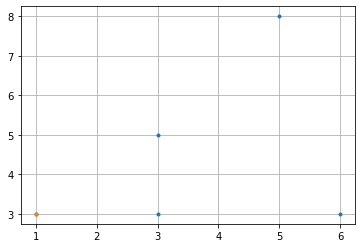

In [4]:
plt.plot(xs, ys, '.')
plt.plot(center[0], center[1], '.')
plt.grid()

In [5]:
def distance(p1, p2):
    x1, x2 = p1[0], p2[0]
    y1, y2 = p1[1], p2[1]
    return math.hypot(x2 - x1, y2 - y1)

In [6]:
distance_matrix = [[distance(locations[i], locations[j]) 
                    for i in range(locations_count)] 
                    for j in range(locations_count)]
distance_matrix

[[0.0, 5.0, 2.0, 2.8284271247461903, 6.4031242374328485],
 [5.0, 0.0, 3.0, 3.6055512754639896, 5.099019513592785],
 [2.0, 3.0, 0.0, 2.0, 5.385164807134505],
 [2.8284271247461903, 3.6055512754639896, 2.0, 0.0, 3.6055512754639896],
 [6.4031242374328485,
  5.099019513592785,
  5.385164807134505,
  3.6055512754639896,
  0.0]]

In [7]:
distance(center, locations[1])

5.0

In [8]:
print(center)
print(locations[1])

[1. 3.]
[6. 3.]


In [9]:
solver = pywraplp.Solver.CreateSolver('SAT')

x = [[[solver.NumVar(0, 1, 'x_%s_%s,%s'%(i, j, k)) 
        for k in range(vehicle_count)] 
        for i in range(locations_count)] 
        for j in range(locations_count)]

objective_terms = [ distance_matrix[i][j] * x[i][j][k] if i!=j else 0
                   for k in range(vehicle_count) 
                   for i in range(locations_count) 
                   for j in range(locations_count) ]

solver.Minimize(solver.Sum(objective_terms))

In [10]:
# constraint 1
for i in range(locations_count):
    constraint1 = [ x[i][j][k] if i!=j else 0
                   for k in range(vehicle_count) 
                   for j in range(locations_count) ]
    solver.Add(solver.Sum(constraint1) == 1)
    
# constraint 2
for k in range(vehicle_count):
    for t in range(locations_count):
        constraint2_1 = [x[i][t][k] for i in range(locations_count)]
        constraint2_2 = [x[t][j][k] for j in range(locations_count)]
        solver.Add((solver.Sum(constraint2_1) - solver.Sum(constraint2_2)) == 0)

In [11]:
solver.Solve()

0

In [12]:
solver.Objective().Value()

16.31012201309204